## Loading Essentials and Helper Functions 

In [1]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

In [2]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

## Background: Dataset Information

I will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. I will classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (male/female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data


In [3]:
# Preprocess Data

# Load Data
data = pd.read_csv("datasets/heartdisease.csv")

# Transform target feature into numerical
le = LabelEncoder()
data["target"] = le.fit_transform(data["sick"])
data["sex"] = le.fit_transform(data["sex"])
data = data.drop(["sick"], axis=1)

# Split target and data
y = data["target"]
x = data.drop(["target"], axis=1)

# Train test split
# 40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(
    x, y, test_size=0.4, stratify=y, random_state=0
)

# Feature Transformation
# This is the only change from project 2 since we replaced standard scaler to minmax
# This was done to ensure that the numerical features were still of the same scale
# as the one hot encoded features
num_pipeline = Pipeline([("minmax", MinMaxScaler())])

heart_num = train_raw.drop(
    ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"], axis=1
)
numerical_features = list(heart_num)
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories="auto"), categorical_features),
    ]
)

# Transform raw data|
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)  # Note that there is no fit calls

# Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [4]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [5]:
# Baseline accuracy of using the majority class
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print(
    "==========================================",
    "\nBaseline Accuraccy of using Majority Class:",
    np.round(np.max(ct) / np.sum(ct), 3),
)

Counts of each class in target_test: 
target
0    66
1    56
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class: 0.541


## Decision Trees

### Apply  Decision Tree on Train Data



Accuracy:    0.713115
Confusion Matrix: 
 [[54 12]
 [23 33]]


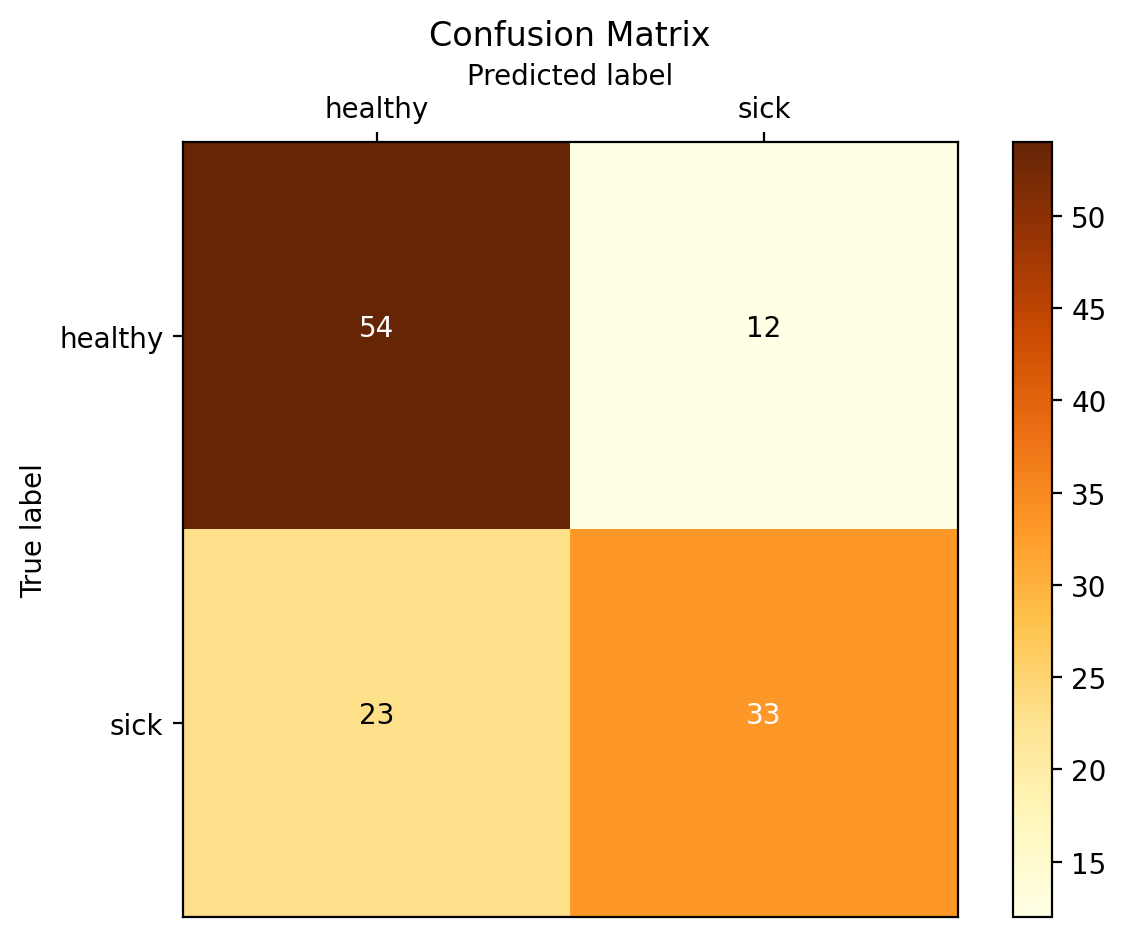

In [6]:
# TODO
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(train,target)
predicted = clf.predict(test)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["healthy", "sick"])


### Visualize the Decision Tree


[Text(0.4230769230769231, 0.875, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.15384615384615385, 0.625, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 18.2%\nvalue = [1.0, 0.0]'),
 Text(0.23076923076923078, 0.375, 'cat__slope_2 <= 0.5\ngini = 0.397\nsamples = 30.4%\nvalue = [0.727, 0.273]'),
 Text(0.15384615384615385, 0.125, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.125, '\n  (...)  \n'),
 Text(0.6923076923076923, 0.625, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.5384615384615384, 0.375, 'cat__exang_0 <= 0.5\ngini = 0.115\nsamples = 27.1%\nvalue = [0.061, 0.939]'),
 Text(0.46153846153846156, 0.125, '\n  (...)  \n'),
 Text(0.6153846153846154, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.375, 'cat__thal_3 <= 0.5\ngini = 0.499\nsamples = 24.3%\nvalue = [0.523, 0.477]'),
 Text(0.7692307692307693, 0.125, '\n  (...)  

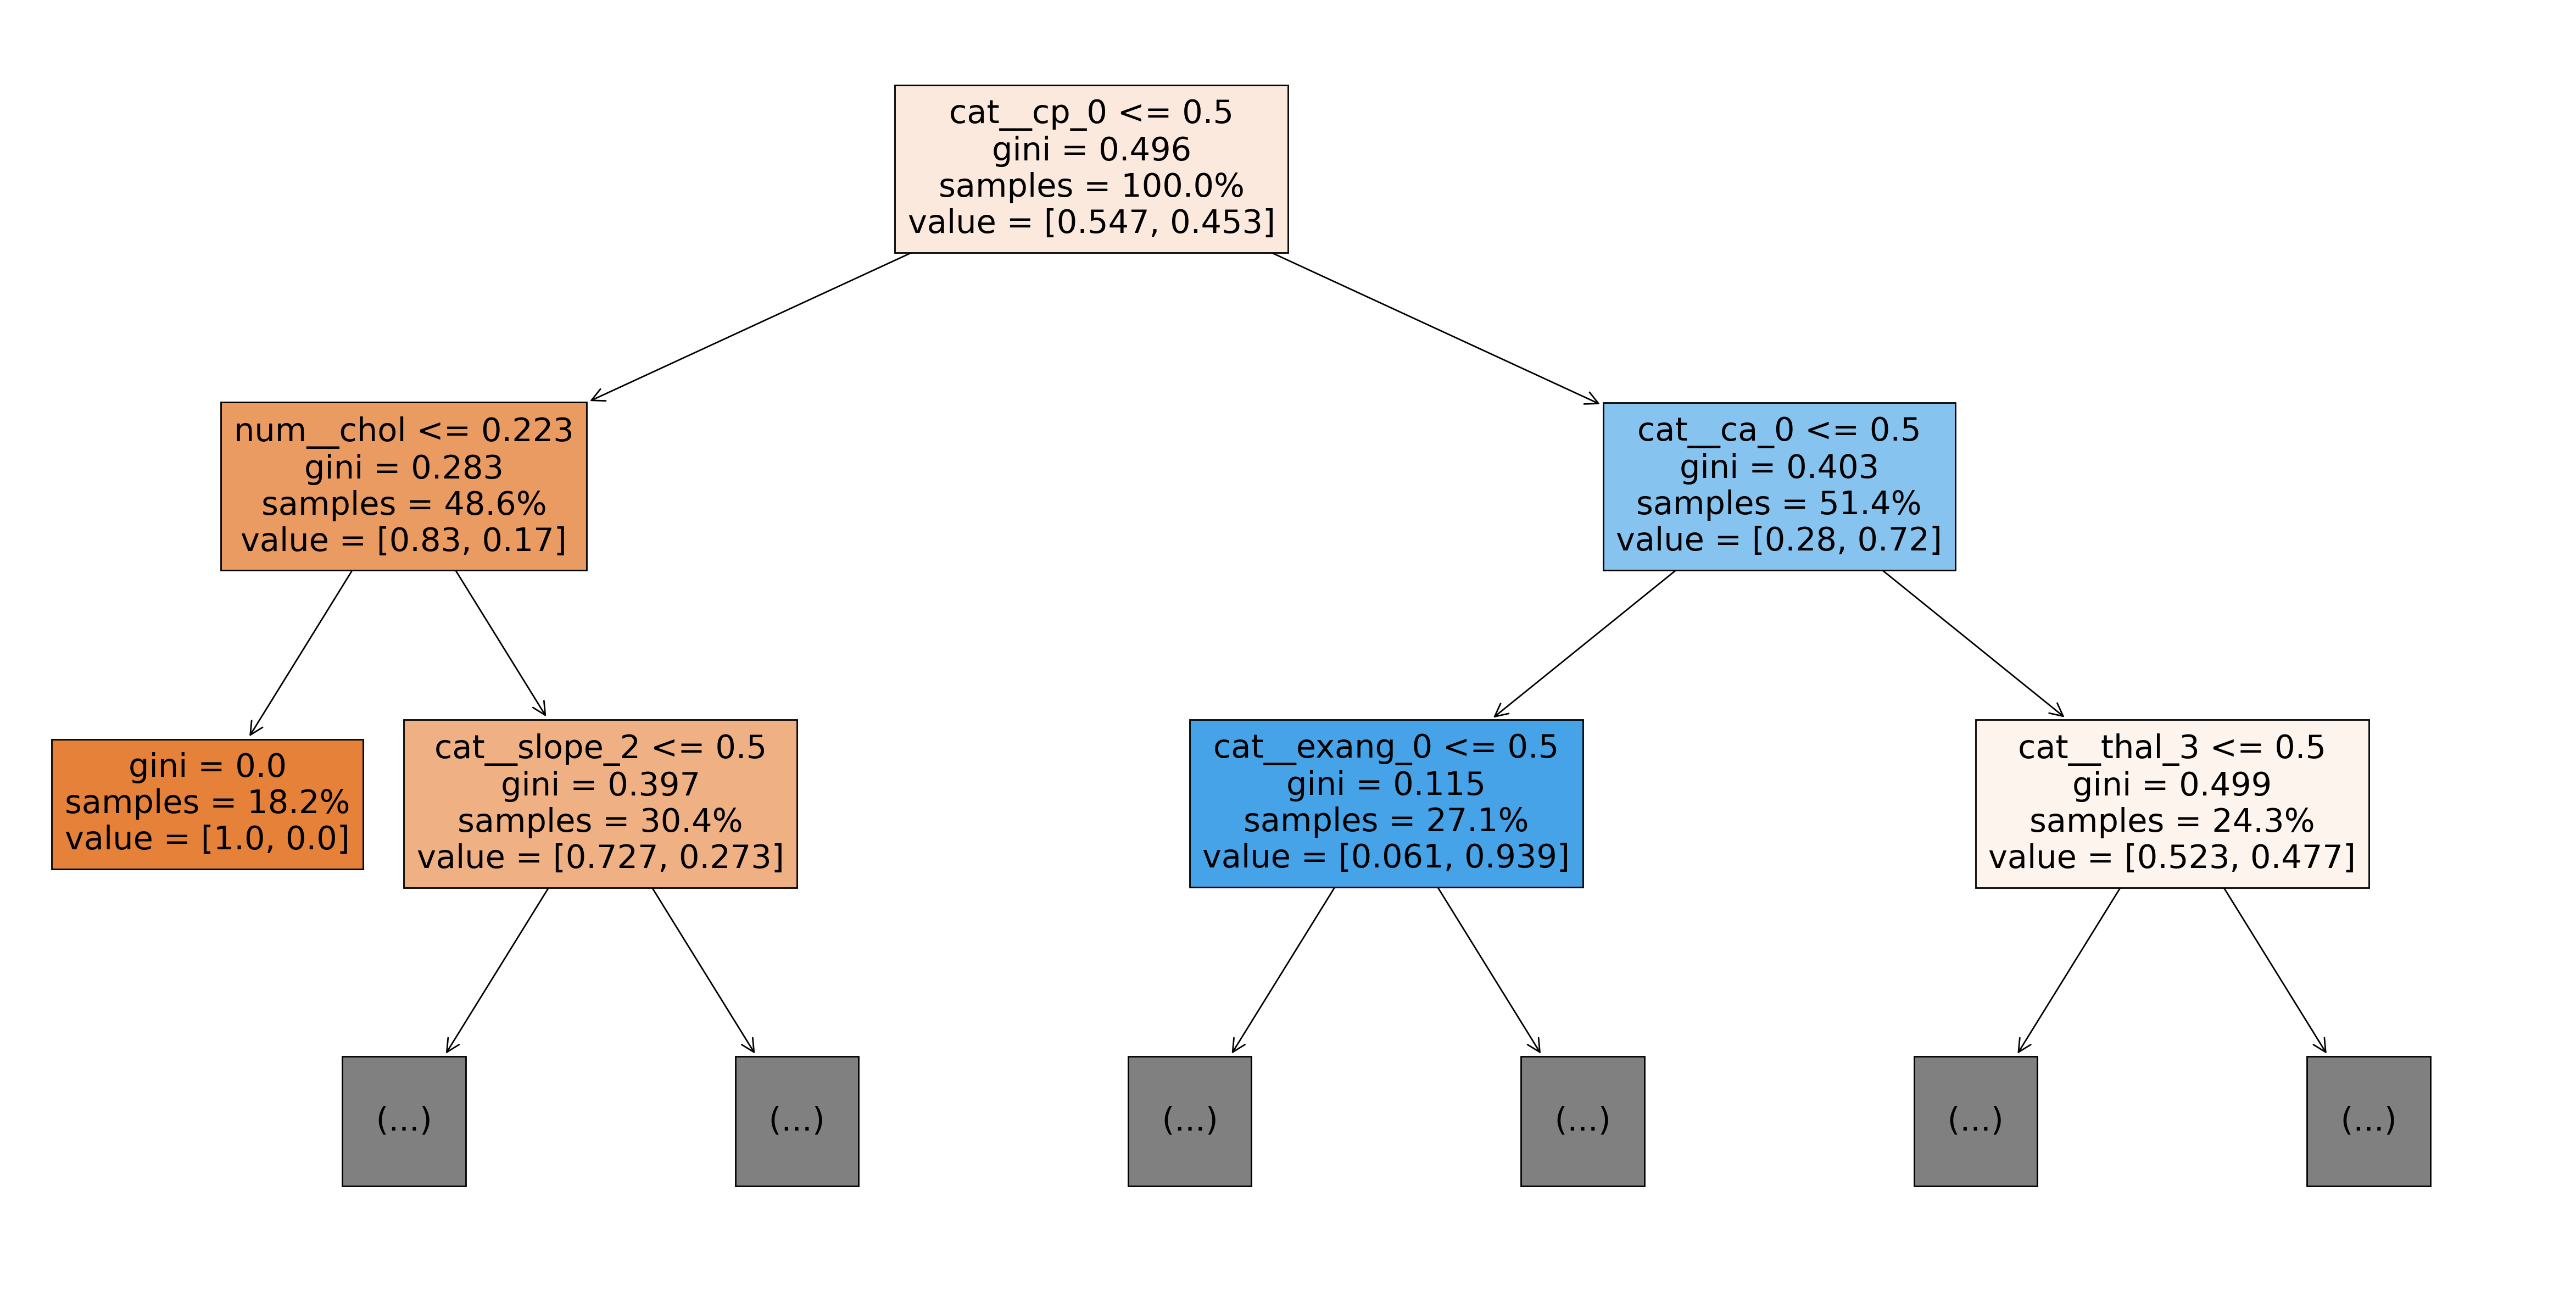

In [7]:
# TODO
plt.figure(figsize=(30, 15))
tree.plot_tree(
    clf, max_depth=2, proportion=True, feature_names=feature_names, filled=True
)


**What is the gini index improvement of the first split?**

In [8]:
gini_index_improvement = 0.496-0.283*0.486-0.403*0.514
print(gini_index_improvement)


0.15131999999999998


Response: Roughly 0.35

###  Plot the importance of each feature for the Decision Tree

Text(0.5, 1.0, "Decision Tree's Feature Importance")

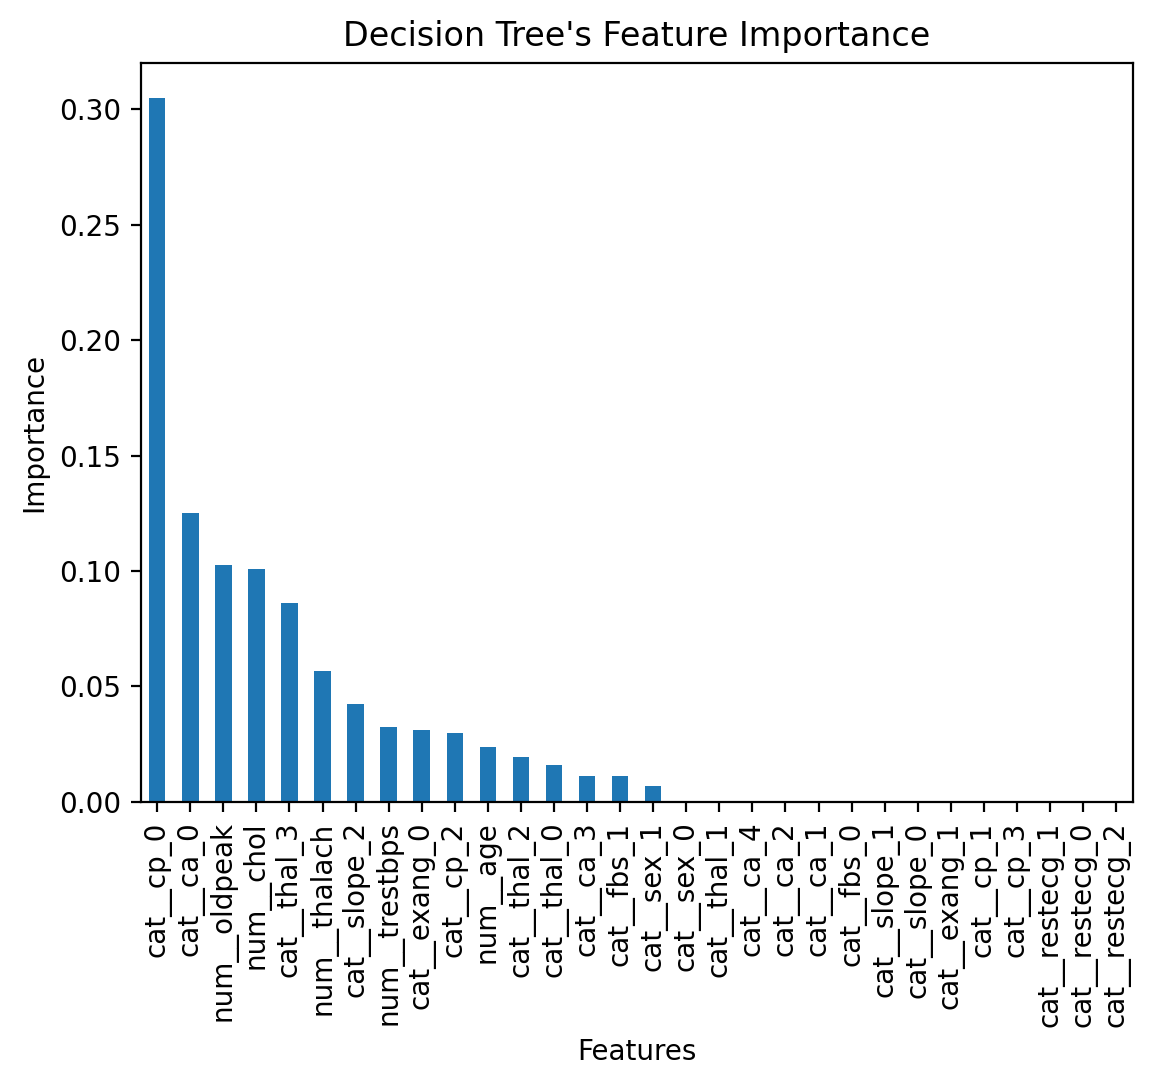

In [9]:
# TODO
imp_pd = pd.Series(data=clf.feature_importances_, index=feature_names)
imp_pd = imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Decision Tree's Feature Importance")

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

In [10]:
feat_importance = clf.feature_importances_
nonzero_features = np.count_nonzero(feat_importance)
print("# of features with non-zero importance: ", nonzero_features)

X_nonzero_features = train[:, feat_importance > 0]
clf_nonzero = DecisionTreeClassifier(random_state=SEED)
clf_nonzero.fit(X_nonzero_features,target)

if clf.tree_.max_depth == clf_nonzero.tree_.max_depth:
    print("Does not change decision tree")
else:
    print("Does change")


# of features with non-zero importance:  16
Does not change decision tree


Response: There are 16 features that have non-zero importance for the Decision Tree. If we remove the features with 0 importance, it will NOT change the decision tree for the same sampled dataset.

### Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a `GridSearchCV` with 5-Fold Cross Validation for the Decision Tree. Find the best model parameters for accuracy



In [11]:
# TODO
DTC = DecisionTreeClassifier()
parameters = [
    {
        'max_depth': [2,4,8,16,32],
        'min_samples_split': [2,4,8,16],
        'criterion': ["gini","entropy"],
    },
]

grid = GridSearchCV(DTC,param_grid=parameters,cv=5,scoring = "accuracy")
grid.fit(train,target)

res = pd.DataFrame(grid.cv_results_)
res = res.sort_values('rank_test_score').head(5)

res[['rank_test_score', 'param_max_depth', 'param_min_samples_split', 'param_criterion', 'mean_test_score', 'std_test_score']]

,rank_test_score,param_max_depth,param_min_samples_split,param_criterion,mean_test_score,std_test_score
13,1,16,4,gini,0.757057,0.080708
33,2,16,4,entropy,0.746096,0.102289
9,3,8,4,gini,0.745946,0.072888
12,4,16,2,gini,0.740991,0.092824
8,5,8,2,gini,0.740691,0.076172


**Using the best model you have, report the test accuracy and print out the confusion matrix**

Decision Tree Best Model Accuracy: 0.713115


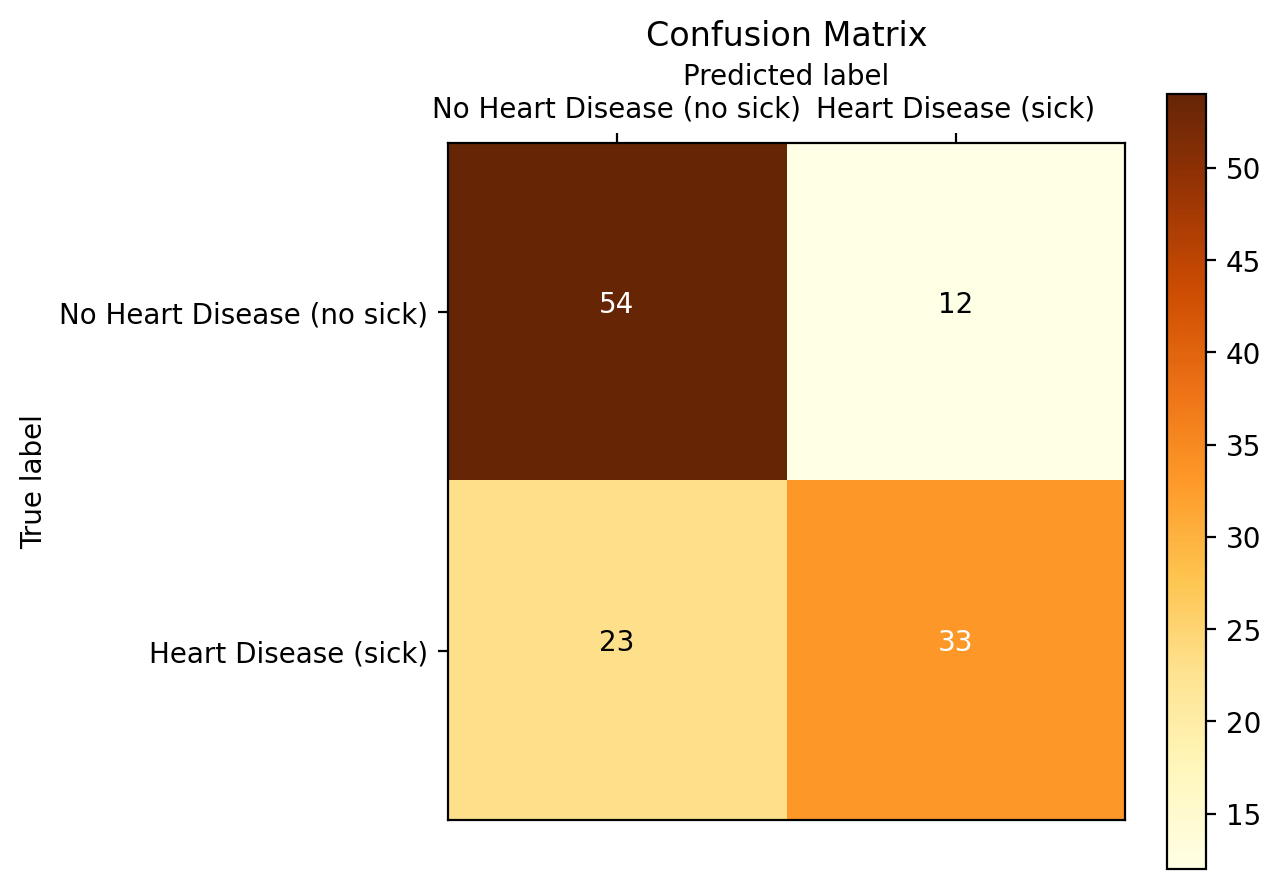

In [13]:
# TODO
clf = DecisionTreeClassifier(max_depth=32,
                             min_samples_split=2,
                             criterion="gini",
                             random_state=SEED)
clf.fit(train,target)
predicted = clf.predict(test)
print("%-12s %f" % ('Decision Tree Best Model Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['No Heart Disease (no sick)', 'Heart Disease (sick)'])

### Applying a Multi-Layer Perceptron
 

Accuracy:    0.819672
Confusion Matrix: 
 [[62  4]
 [18 38]]


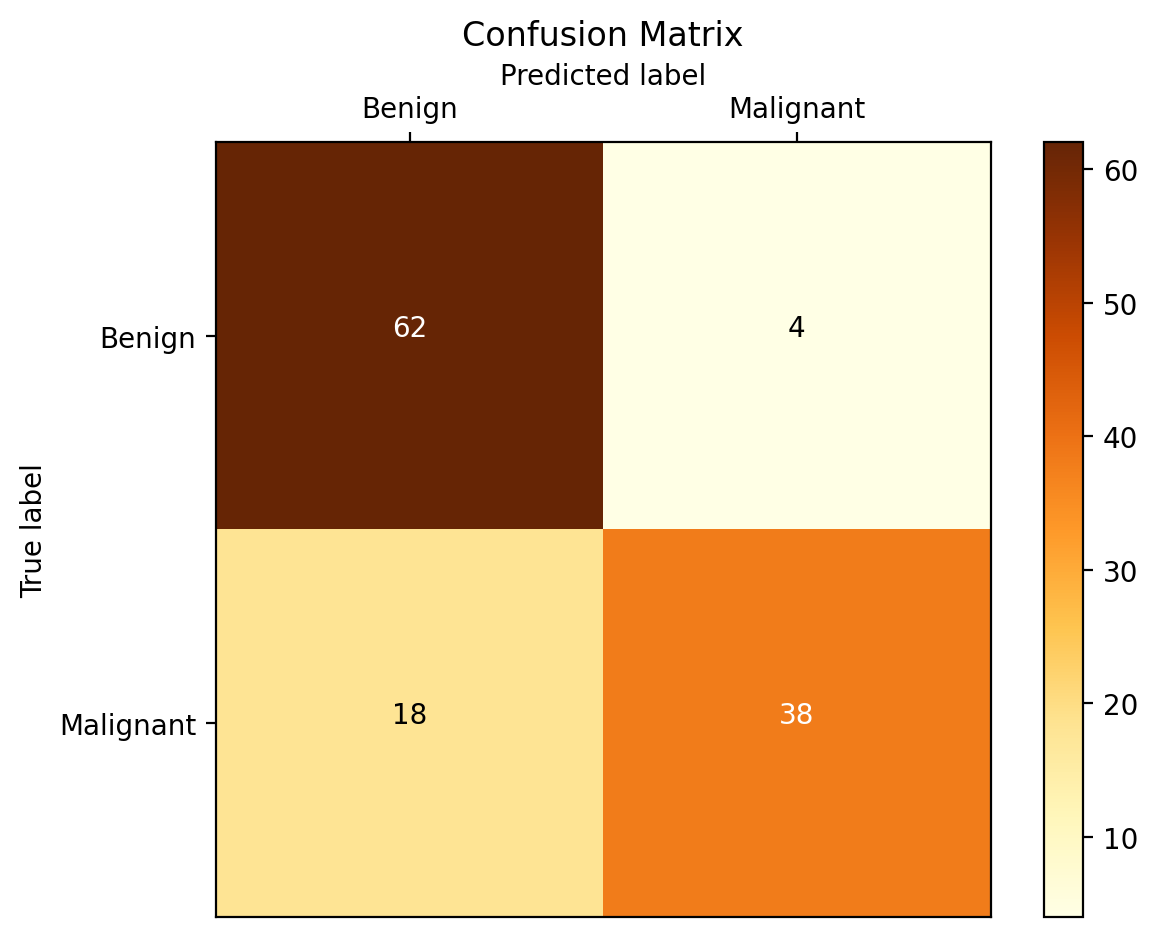

In [14]:
# TODO
clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)
clf.fit(train, target)
predicted = clf.predict(test)
print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["Benign", "Malignant"])

### Speedtest between Decision Tree and MLP

In [37]:
# TODO
clf = DecisionTreeClassifier(random_state=SEED)
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)

# Timing Training for DTs
start = time.time()
clf.fit(train,target)
decision_tree_training_time = time.time() - start

#Timing Training for MLP
start = time.time()
mlp.fit(train, target)
MLP_training_time = time.time() - start

# Timing Prediction for decision trees
start = time.time()
clf.predict(test)
decision_tree_prediction_time = time.time() - start

# Timing Prediction for MLP
start = time.time()
mlp.predict(test)
MLP_prediction_time = time.time() - start

#Printing Training Times
print("Time to take Decision tree to train its model: {:.20f} seconds".format(decision_tree_training_time)) 
print("Time to take MLP to train its model: {:.20f} seconds".format(MLP_training_time)) 
print()
#Printing prediction times
print("Time to take Decision tree to predict its model: {:.20f} seconds".format(decision_tree_prediction_time)) 
print("Time to take MLP to predict its model: {:.20f} seconds ".format(MLP_prediction_time)) 

Time to take Decision tree to train its model: 0.00453948974609375000 seconds
Time to take MLP to train its model: 0.49696350097656250000 seconds

Time to take Decision tree to predict its model: 0.00065350532531738281 seconds
Time to take MLP to predict its model: 0.00006890296936035156 seconds 


Decision Trees were much quicker than the MLP for training.
MLP were much quicker than Decision trees for predicting

### Compare and contrast Decision Trees and MLPs.

Advantages of using an MLP over a decision tree are its ability to capture complex relationships in the dataset between the input features and output labels. In addition, they can model non-linear relationships and also capture interesting patterns in the data. Finally, it allows MLPs to achieve higher prediction accuracy for complex data tasks.

Disadvantages of using an MLP over a decision tree are the longer, complexity of training time. It can be computationally intensive to train datasets. The training time for MLP can be much longer as seen in the previous code block using time(), especially if MLP has alot of hidden layers and a large # of neurons. Lastly, it can often require a lot of hyperparameters tuning to achieve good performance, which ADDS to the training time :(

### Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components.

In [40]:
# TODO
pca = PCA(n_components=10)
pca.fit(train, target)
print(pca.components_)


[[ 6.09946635e-02  4.03486405e-02  1.92458119e-02 -1.01732201e-01
   1.10715411e-01 -1.23314342e-01  1.23314342e-01  3.42653325e-01
  -1.34589184e-01 -2.09361216e-01  1.29707586e-03 -1.28849271e-02
   1.28849271e-02  1.96937289e-01 -1.98556306e-01  1.61901735e-03
  -3.50544191e-01  3.50544191e-01  4.59558653e-02  2.94123242e-01
  -3.40079107e-01 -2.05535178e-01  7.46326307e-02  8.34805264e-02
   6.75833376e-02 -2.01613171e-02 -3.90382012e-04  4.43852832e-02
  -3.14081117e-01  2.70086216e-01]
 [ 5.23178867e-02  2.89025067e-02  3.82650356e-02 -7.33246302e-03
  -3.72850287e-03  4.44422145e-01 -4.44422145e-01  7.36224643e-02
  -3.17147806e-02 -2.86078655e-02 -1.32998182e-02 -2.10653488e-02
   2.10653488e-02  4.25893739e-01 -4.44476340e-01  1.85826015e-02
   1.84907981e-02 -1.84907981e-02 -2.18311052e-02  1.43545701e-01
  -1.21714596e-01  2.01177502e-02 -3.19965459e-02  3.69926555e-02
   3.82437776e-03 -2.89382375e-02  3.36806325e-03  3.01278536e-03
   2.90071072e-01 -2.96451921e-01]
 [-4.2

### Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [41]:
# TODO
# print(pca.explained_variance_ratio_)
for i in range(len(pca.explained_variance_ratio_)):
    print("Principal Component {}: {:.2f}%".format(i+1, pca.explained_variance_ratio_[i]*100))

Principal Component 1: 23.86%
Principal Component 2: 13.60%
Principal Component 3: 10.03%
Principal Component 4: 8.24%
Principal Component 5: 7.50%
Principal Component 6: 6.59%
Principal Component 7: 5.92%
Principal Component 8: 4.94%
Principal Component 9: 4.04%
Principal Component 10: 2.99%


### Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [42]:
# TODO
train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)

###  PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy with PCA
Accuracy:    0.811475
Confusion Matrix: 
 [[59  7]
 [16 40]]


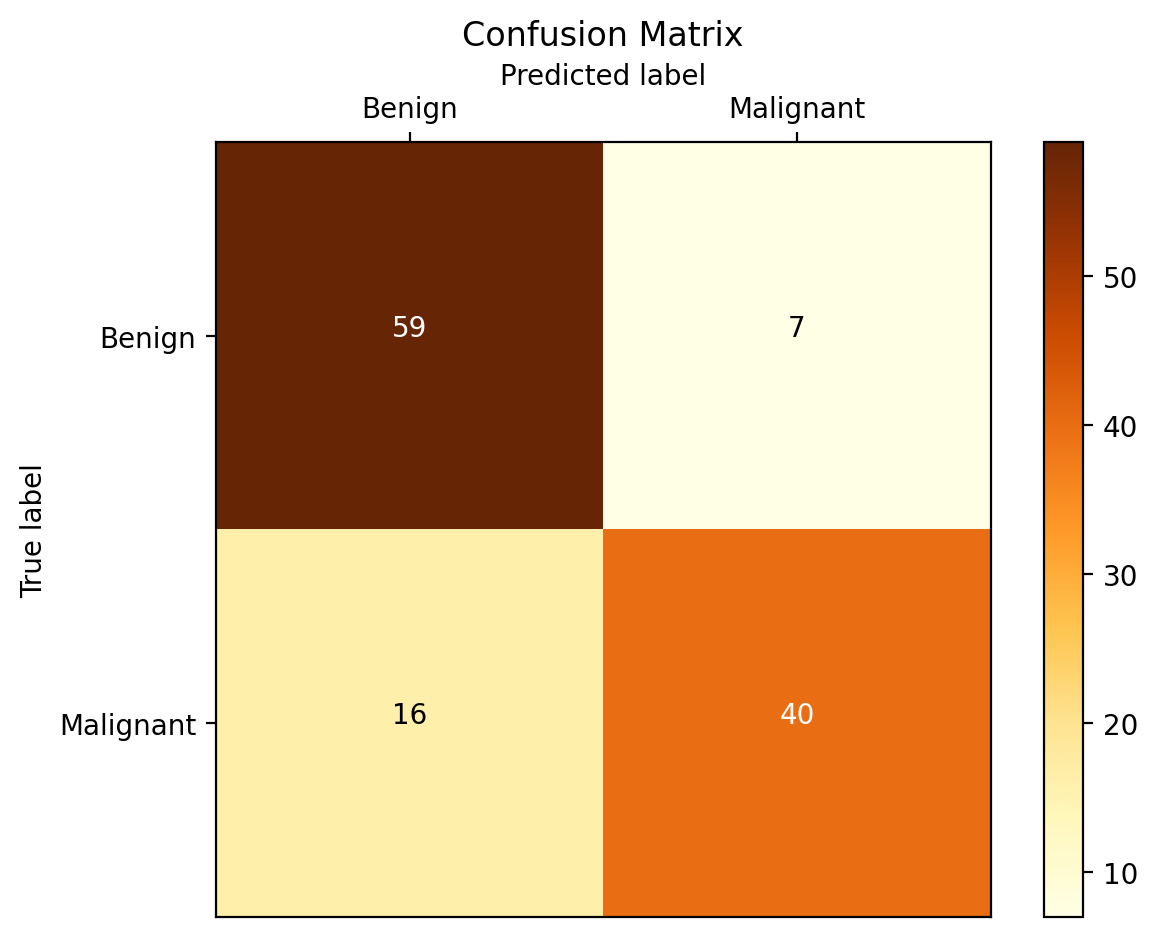

Accuracy without PCA
Accuracy:    0.713115
Confusion Matrix: 
 [[54 12]
 [23 33]]


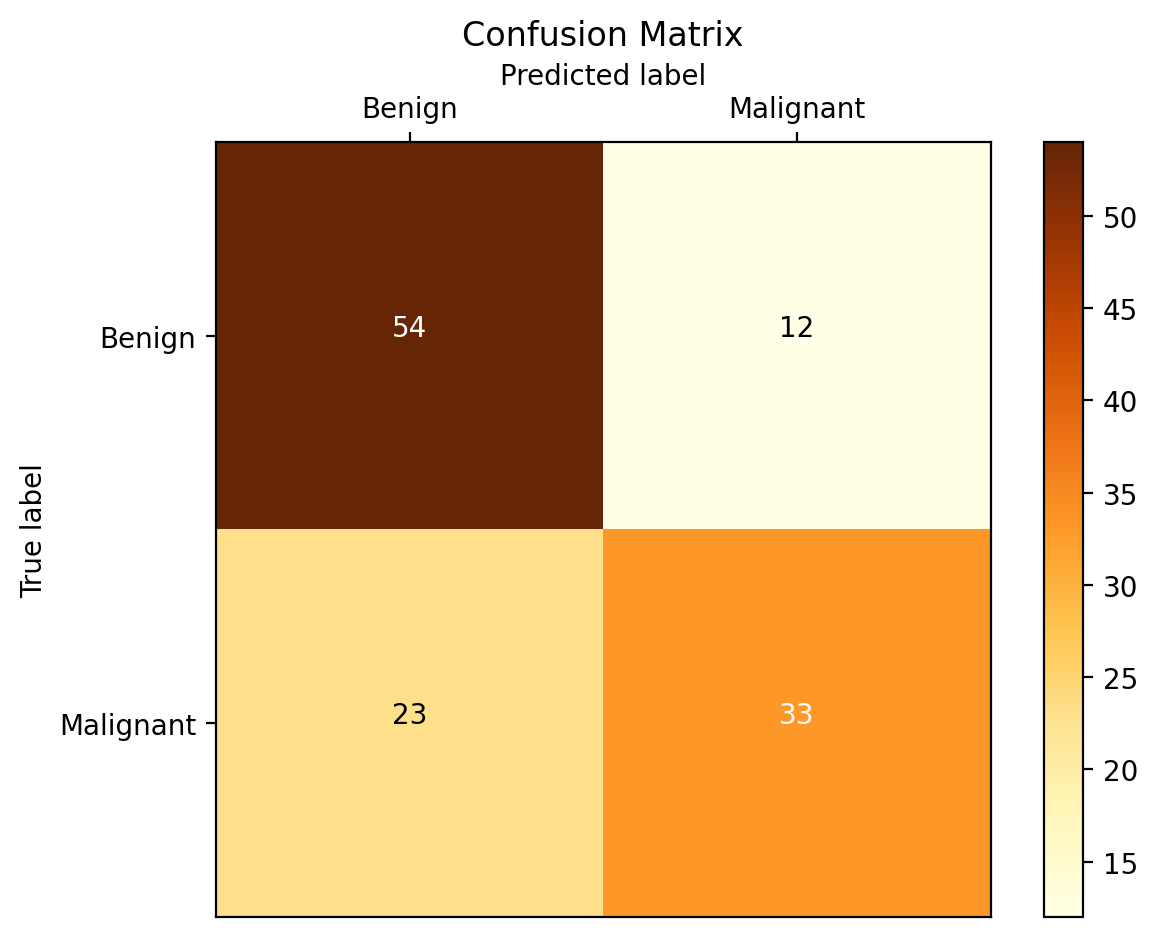

In [43]:
# TODO

clf_pca = DecisionTreeClassifier(random_state=SEED)
clf_pca.fit(train_pca,target)
predicted = clf_pca.predict(test_pca)

print("Accuracy with PCA")
print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["Benign", "Malignant"])

#-------------------------------------------------------------------------------------

clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(train,target)
predicted = clf.predict(test)

print("Accuracy without PCA")
print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["Benign", "Malignant"])


**Does the model perform better with or without PCA?**

The model performed better with PCA

### PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy with PCA using MLP
Accuracy:    0.803279
Confusion Matrix: 
 [[61  5]
 [19 37]]


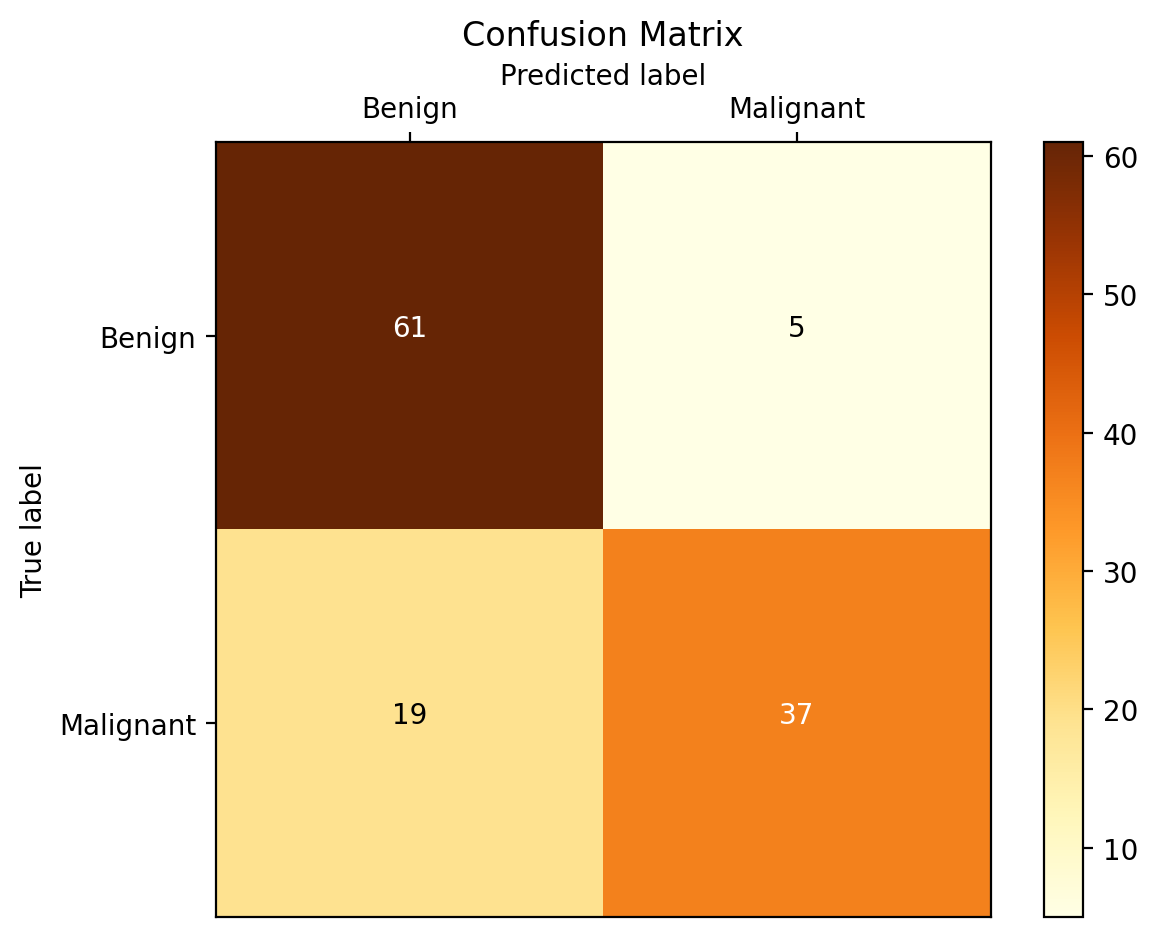

In [44]:
# TODO
clf_pca = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)
clf_pca.fit(train_pca, target)
predicted = clf_pca.predict(test_pca)
print("Accuracy with PCA using MLP")
print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["Benign", "Malignant"])

#-----------------------------------------------------------


**Does the model perform better with or without PCA?**

The model performed better without PCA

### Pros and Cons of PCA

**At least two pros and at least two cons for using PCA**


Pros of PCA: PCA allows for feature extract a smaller sets of non-correlated variable, such as the principal components. PCA also capture the max variance in the data. The principal components also represent the informative and relevant features of the original dataset. Therefore, PCA allows for interpretability enhancement of the model, as well as we can also simplify the data representation. In addition, PCA helps reduce the dimensionality of the dataset by turning/tranforming original features into a lower-dimensional space. 

Cons of PCA: It involves in some degree of information loss because the transformed features like the principal components are of linear combinations of the original features. Although it captures the maximum/almost all the variance, they may not retain all the subtle patterns in the original features. So there is a trade off between dimensionality reduction & saving of specific info. Also, the transformed features themselves may not be directly interpretable in the context of meaningful features. So this may limit insights in the real world.

### Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and `random_state = SEED`.

In [45]:
# TODO
n_clusters = 5
inertia = []
km = KMeans(n_clusters=n_clusters, random_state=SEED)
km.fit(train)
inertia.append(km.inertia_)

print(f"Inertia for K = {n_clusters}: {inertia}")


Inertia for K = 5: [489.04880651627343]


### Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. 

Inertia for K = 2: 619.30
Inertia for K = 3: 561.53
Inertia for K = 4: 515.09
Inertia for K = 5: 489.05
Inertia for K = 6: 470.33
Inertia for K = 7: 444.00
Inertia for K = 8: 426.30
Inertia for K = 9: 407.75
Inertia for K = 10: 401.96
Inertia for K = 11: 387.55
Inertia for K = 12: 371.74
Inertia for K = 13: 359.22
Inertia for K = 14: 350.70
Inertia for K = 15: 348.51
Inertia for K = 16: 342.60
Inertia for K = 17: 328.49
Inertia for K = 18: 319.41
Inertia for K = 19: 310.68
Inertia for K = 20: 304.17
Inertia for K = 21: 296.25
Inertia for K = 22: 288.43
Inertia for K = 23: 280.92
Inertia for K = 24: 271.06


C:\Users\bryce\AppData\Local\Temp\ipykernel_14308\2747298999.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

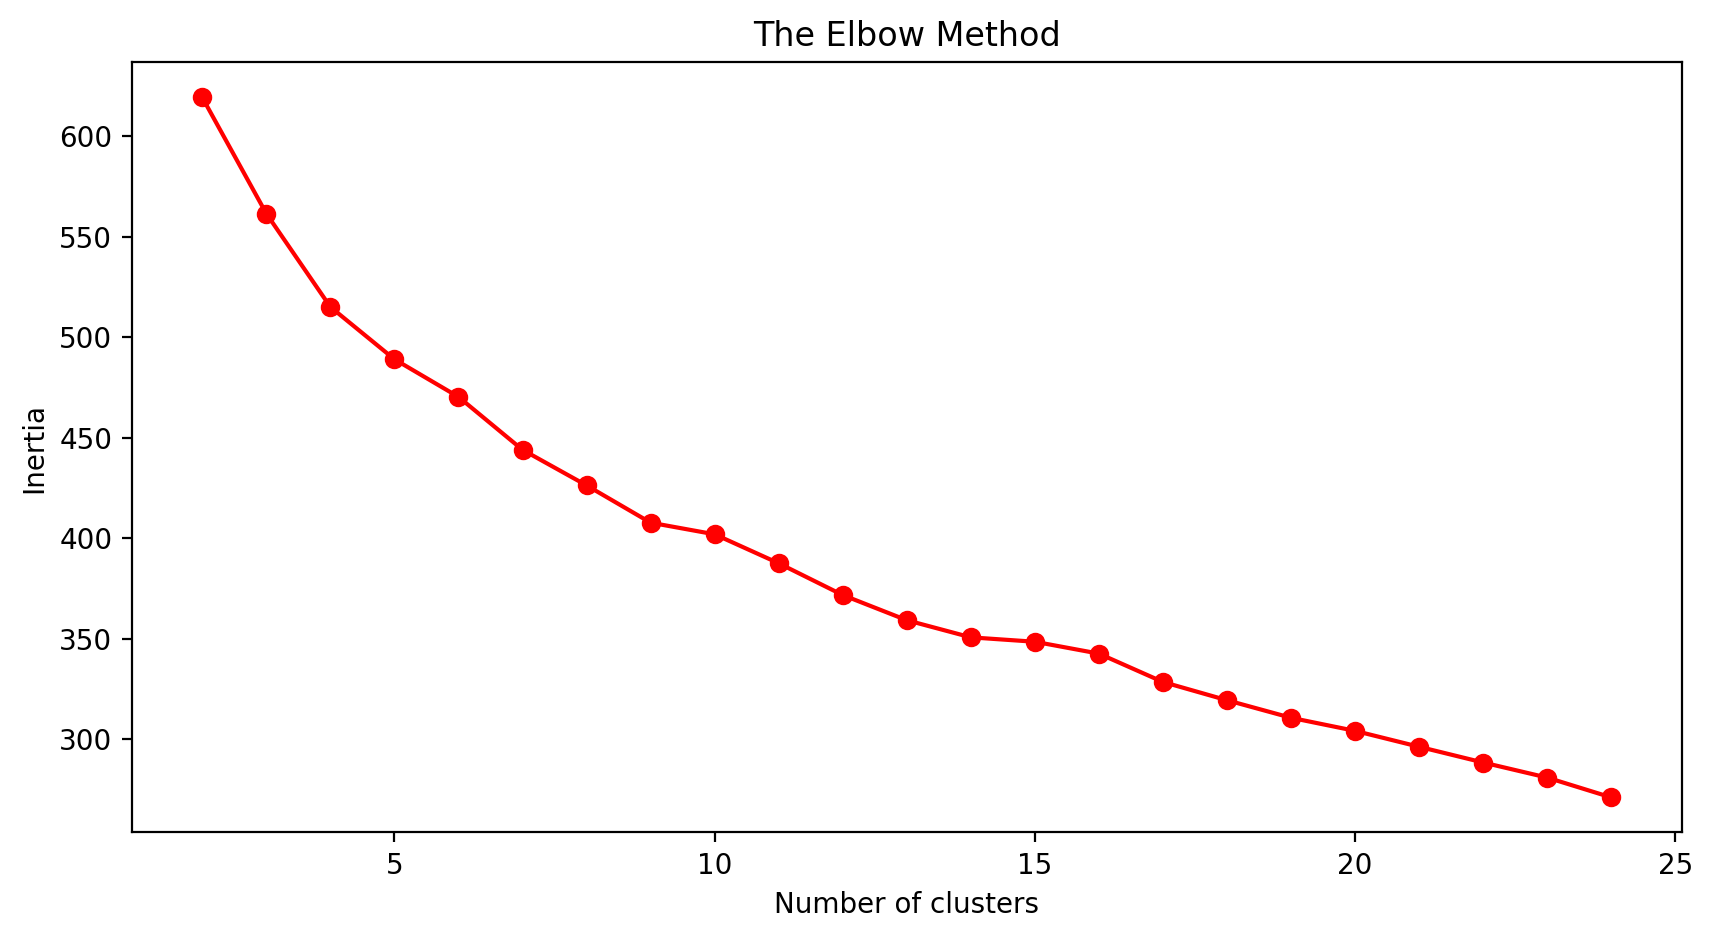

In [46]:
# TODO
ks = list(range(2,25))
inertia = []
for k in ks:
    km = KMeans(n_clusters=k,init="k-means++", random_state=SEED)
    km.fit(train)
    inertia.append(km.inertia_)
    print(f"Inertia for K = {k}: {km.inertia_:.2f}")
    plt.figure(figsize=(10, 5))
    
plt.plot(ks, inertia, marker="o", color="red")
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

From the plot, we can guess that the best cluster size is somewhere between 5 and 10.

### Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

In [47]:
# TODO
n_clusters = 5
inertia = []
km = KMeans(n_clusters=n_clusters, random_state=SEED)
km.fit(train_pca)
inertia.append(km.inertia_)

print(f"Inertia for K = {k}: {km.inertia_}")


Inertia for K = 24: 411.3696894350428


Inertia for K = 2: 526.90
Inertia for K = 3: 481.68
Inertia for K = 4: 433.93
Inertia for K = 5: 411.37
Inertia for K = 6: 375.19
Inertia for K = 7: 382.90
Inertia for K = 8: 342.35
Inertia for K = 9: 325.73
Inertia for K = 10: 310.24
Inertia for K = 11: 287.75
Inertia for K = 12: 290.90
Inertia for K = 13: 278.22
Inertia for K = 14: 264.23
Inertia for K = 15: 256.32
Inertia for K = 16: 243.89
Inertia for K = 17: 233.95
Inertia for K = 18: 229.94
Inertia for K = 19: 227.57
Inertia for K = 20: 220.40
Inertia for K = 21: 213.26
Inertia for K = 22: 205.80
Inertia for K = 23: 196.45
Inertia for K = 24: 193.01


C:\Users\bryce\AppData\Local\Temp\ipykernel_14308\1929508895.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

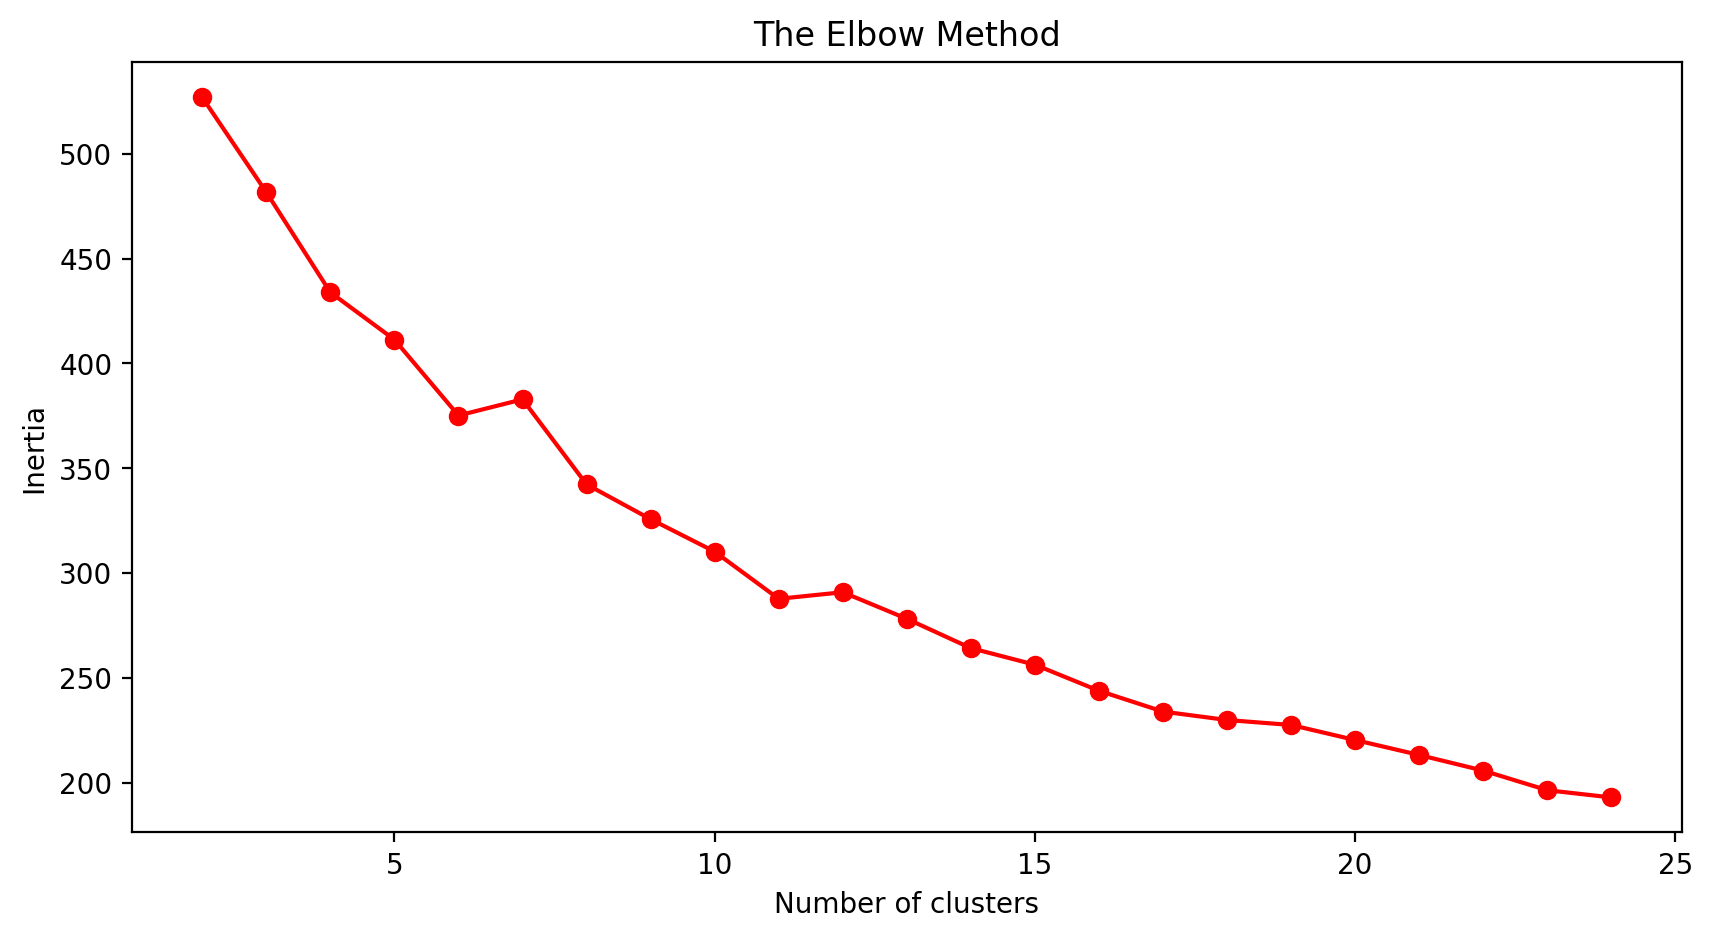

In [48]:
ks = list(range(2,25))
inertia = []
for k in ks:
    km = KMeans(n_clusters=k,init="k-means++", random_state=SEED)
    km.fit(train_pca)
    inertia.append(km.inertia_)
    print(f"Inertia for K = {k}: {km.inertia_:.2f}")
    plt.figure(figsize=(10, 5))
    
plt.plot(ks, inertia, marker="o", color="red")
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

Similar to the previous experiment, we can guess that the best cluster size is somewhere between 5 and 10. Additionally, we see that the inertia is much smaller for every cluster size when using PCA features.

 PCA reduces the number of features in the data sample by turning it into a lower-dimensionality space, i.e dimensional reduction while also capturing the most important information. In addition, the inertia is calculated as the summation of squared distances of the data samples to their closest cluster center. When the dimensions is reduced, the variability in the data is compressed into fewer dimensions. It leads to an overall spread in the data or dispersion --> smaller distances between samples and their cluster centers. 